In [2]:
from zipfile import ZipFile
file_name = "coldropDS-50k.zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


Importing libraries

In [3]:
#imports

import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import nltk
import re
import string
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [4]:
#dataset links source and destination

URL_UNCLEAN = "/content/coldropDS-50k.csv"
URL_CLEAN = "/content/coldropDS-50k_cleaned.csv"

**Dataframe preprocessing**

In [5]:
# splits review rating into different classes, say positive(2), neutral(1) and negative(0). 
def classify(x):
    if x == 5.0 or x==4.0:
        return 2
    if x==3.0:
        return 1 
    return 0

In [6]:
def clean_dataframe(df):
  # creates new column with corresponding class labels, the output variable.
  df['y'] = df['overall'].apply(classify)

  # dropping uneccesary columns for the analysis
  df = df.drop(labels=['Unnamed: 0', 'verified','asin' ,'style','reviewerName',  'description','title', 'rank', 'main_cat' ],axis=1)
  
  # dropping all NaN values from the column reviewText
  df = df.dropna(axis=0, subset=['reviewText'])
  return df

In [7]:
# removes all the punctuations for the strings of reviewText, ie '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
def remove_punctuation(text):
    no_punct=[words for words in text if words not in string.punctuation]
    words_wo_punct=''.join(no_punct)
    return words_wo_punct

In [8]:
def text_process(df):
  # Removing all the punctuations from the words, and changing the words to lower case to maintain uniformity
  df['reviewText']=df['reviewText'].apply(lambda x: remove_punctuation(x.lower()))
  # stemming
  stemmer = PorterStemmer()
  # stop words are the words like "the, I, our etc"
  words = stopwords.words("english") 
  df['cleaned_reviews'] = df['reviewText'].apply(lambda x: " ".join([stemmer.stem(i) for i in re.sub("[^a-zA-Z]", " ", x).split() if i not in words]).lower())
  return df

In [9]:
def process_df(df):
  df = clean_dataframe(df)
  df = text_process(df)
  return df

In [10]:
# reading dataset and writing cleaned version to it
def main(URL_CLEAN=URL_CLEAN, URL_UNCLEAN=URL_UNCLEAN):
  df_unclean = pd.read_csv(URL_UNCLEAN)
  print("UNCLEANED DATASET HEAD:\n",df_unclean.head(),"\n")

  df_clean = process_df(df_unclean)
  print("CLEANED DATASET HEAD:\n",df_clean.head(),"\n")

  #writing to dataframe
  df_clean.to_csv(URL_CLEAN)

In [11]:
main()

UNCLEANED DATASET HEAD:
    Unnamed: 0  ...              main_cat
0     4359171  ...  Home Audio & Theater
1     3938786  ...        Camera & Photo
2     6176764  ...       All Electronics
3     1546547  ...       All Electronics
4     3178737  ...       All Electronics

[5 rows x 12 columns] 

CLEANED DATASET HEAD:
    overall  ...                                    cleaned_reviews
0      5.0  ...              love thing suppli batteri dead replac
1      5.0  ...                      great valu good rang easi use
2      5.0  ...          smallest thumb drive ever cant beat price
3      5.0  ...  bought webcam mostli price fact logitech prett...
4      5.0  ...  got mom she tech savvi set she problem one tim...

[5 rows x 5 columns] 



# **Exploratory data analysis**

In [12]:
# cleaned dataset location
URL = "/content/coldropDS-50k_cleaned.csv"

In [13]:
#importing necessary visualisation libraries

import torch #the pytorch library, used for modeling and formatting our data to be compatible in a pytorch environment
import pandas as pd #for dataframe reading, cleaning functions
from tqdm.notebook import tqdm #used as a progress bar

# Importing necessary libraries for basic visualization as well as word clouds
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer

# Using textblob to generate sentiment for easy visualization
from textblob import TextBlob

In [14]:
# reading the dataset
df = pd.read_csv(URL)

In [15]:
# Changes the overall category to categorical from numerical for easier visualizations
df["classes"] = df["overall"]
df["classes"].replace({5.0: "positive",4.0:"positive",3.0:"neutral",2.0:"negative",1.0:"negative"}, inplace=True)
df["classes"].unique()

array(['positive', 'negative', 'neutral'], dtype=object)

In [16]:
# Dropping null values to have a cleaner dataset
df = df.dropna(subset=['cleaned_reviews'])

**Distribution of sentiment classes across the dataset**

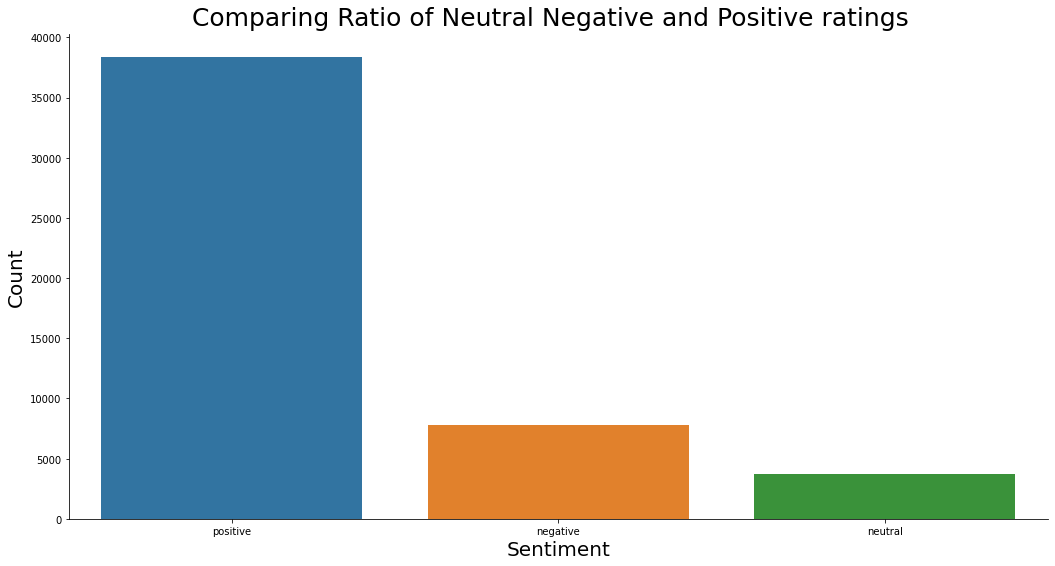

In [17]:
# Distribution of sentiment class
fig, axes = plt.subplots(1, figsize=(15,8))
fig.suptitle("Comparing Ratio of Neutral Negative and Positive ratings", fontsize = 25)
plt.tight_layout(pad = 3.5)
sns.countplot(x = "classes", data = df)
axes.set_xlabel("Sentiment", fontsize = 20)
axes.set_ylabel("Count", fontsize = 20)
sns.despine()

In [18]:
# Percentage of neutral, negative, positive words in train and test data
def pert_count(data, category):
    return (len(data[data["classes"] == category])/len(data)) * 100
print(f"Percentage of neutral words in train --> {pert_count(df, 'neutral')} %")
print(f"Percentage of negative words in train --> {pert_count(df, 'negative')} %")
print(f"Percentage of positive words in train --> {pert_count(df, 'positive')} %")

Percentage of neutral words in train --> 7.456439014620468 %
Percentage of negative words in train --> 15.681954736631285 %
Percentage of positive words in train --> 76.86160624874825 %


**Sentiment distibutions** 

In [19]:
# calculating sentiment polarity using external libraries
df['sentiment'] = df['cleaned_reviews'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
df.head()

,Unnamed: 0,overall,reviewText,summary,y,cleaned_reviews,classes,sentiment
0,0,5.0,love these things the supplied batteries were...,Good headset Replaced batteries,2,love thing suppli batteri dead replac,positive,0.150000
1,1,5.0,great value good range and easy to use,Five Stars,2,great valu good rang easi use,positive,0.750000
2,2,5.0,smallest thumb drive ever cant beat the price,Five Stars,2,smallest thumb drive ever cant beat price,positive,0.000000
3,3,5.0,i bought this webcam mostly because of the pri...,Not a bad webcam for the price.,2,bought webcam mostli price fact logitech prett...,positive,0.155790
4,4,5.0,i got this for my mom shes not the most tech ...,Good webcam,2,got mom she tech savvi set she problem one tim...,positive,0.372619


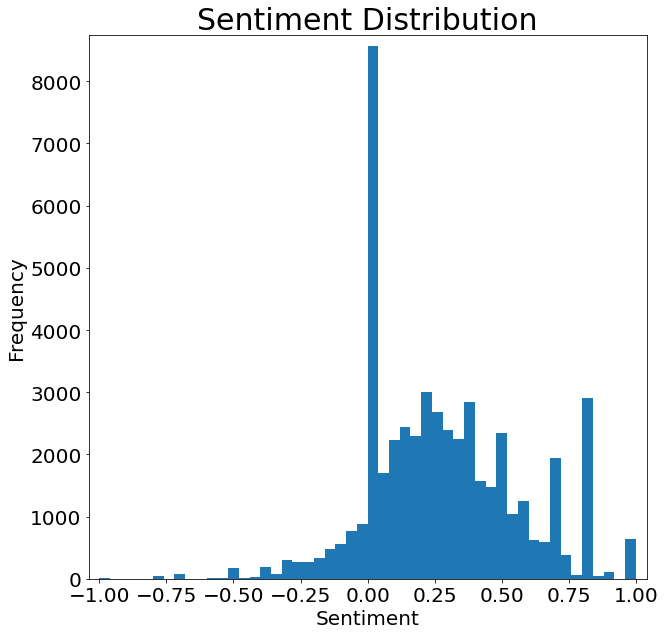

In [20]:
#Barchart using to visualize the sentiment distribution generated above
plt.figure(figsize=(10,10))
plt.margins(0.02)
plt.xlabel('Sentiment', fontsize=20)
plt.xticks(fontsize=20)
plt.ylabel('Frequency', fontsize=20)
plt.yticks(fontsize=20)
plt.hist(df['sentiment'], bins=50)
plt.title('Sentiment Distribution', fontsize=30)
plt.show()

# Deep Learning 

In [21]:
# Test dataset URL
URL = "/content/coldropDS-50k_cleaned.csv"

In [22]:
# importing necessary libraries
import pandas as pd
import numpy as np

In [23]:
# Installing the transformers package for BERT
!pip install transformers

     |████████████████████████████████| 2.6 MB 8.3 MB/s 
     |████████████████████████████████| 636 kB 64.9 MB/s 
     |████████████████████████████████| 3.3 MB 54.2 MB/s 
     |████████████████████████████████| 895 kB 72.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [24]:
import torch
# Progress bar library
from tqdm.notebook import tqdm
# Tokenizer for bert
from transformers import BertTokenizer
# The dataset off which the model will be trained
from torch.utils.data import TensorDataset
# Model
from transformers import BertForSequenceClassification

# Loading the dataframe into memory
df = pd.read_csv(URL)

In [25]:
# Checking the amount of Null values
df['cleaned_reviews'].isna().sum()

54

In [26]:
#Dropping null values as the amount is insignificant
df=df.dropna(subset=['cleaned_reviews'])
df.shape

(49930, 6)

In [27]:
#Displaying dataframe for clarity
df

,Unnamed: 0,overall,reviewText,summary,y,cleaned_reviews
0,0,5.0,love these things the supplied batteries were...,Good headset Replaced batteries,2,love thing suppli batteri dead replac
1,1,5.0,great value good range and easy to use,Five Stars,2,great valu good rang easi use
2,2,5.0,smallest thumb drive ever cant beat the price,Five Stars,2,smallest thumb drive ever cant beat price
3,3,5.0,i bought this webcam mostly because of the pri...,Not a bad webcam for the price.,2,bought webcam mostli price fact logitech prett...
4,4,5.0,i got this for my mom shes not the most tech ...,Good webcam,2,got mom she tech savvi set she problem one tim...
...,...,...,...,...,...,...
49979,49995,5.0,i had e2cs and the wires started to crack this...,Great Company and Earbuds - Can't Beat Them fo...,2,e cs wire start crack common problem shure kno...
49980,49996,5.0,works great,Five Stars,2,work great
49981,49997,4.0,i used it as an adapter for the keyboard that ...,"Which arguably makes it mostly useless, but th...",2,use adapt keyboard came logitec review k datah...
49982,49998,5.0,this is a good overall protective lens used i...,Good protective lens,2,good overal protect len use panason dmc fz car...


In [28]:
#Function that converts overall (5 classes) to y (3 classes) 
def classify(x):
    if x == 5.0 or x==4.0:
        return 2
    if x==3.0:
        return 1
    return 0

In [29]:
# Building column y with the classify function
df['y'] = df['overall'].apply(classify)

In [30]:
#Displaying dataframe for clarity
df

,Unnamed: 0,overall,reviewText,summary,y,cleaned_reviews
0,0,5.0,love these things the supplied batteries were...,Good headset Replaced batteries,2,love thing suppli batteri dead replac
1,1,5.0,great value good range and easy to use,Five Stars,2,great valu good rang easi use
2,2,5.0,smallest thumb drive ever cant beat the price,Five Stars,2,smallest thumb drive ever cant beat price
3,3,5.0,i bought this webcam mostly because of the pri...,Not a bad webcam for the price.,2,bought webcam mostli price fact logitech prett...
4,4,5.0,i got this for my mom shes not the most tech ...,Good webcam,2,got mom she tech savvi set she problem one tim...
...,...,...,...,...,...,...
49979,49995,5.0,i had e2cs and the wires started to crack this...,Great Company and Earbuds - Can't Beat Them fo...,2,e cs wire start crack common problem shure kno...
49980,49996,5.0,works great,Five Stars,2,work great
49981,49997,4.0,i used it as an adapter for the keyboard that ...,"Which arguably makes it mostly useless, but th...",2,use adapt keyboard came logitec review k datah...
49982,49998,5.0,this is a good overall protective lens used i...,Good protective lens,2,good overal protect len use panason dmc fz car...


In [31]:
# Checking distribution of data
df['y'].value_counts()

2    38377
0     7830
1     3723
Name: y, dtype: int64

In [32]:
# Creating a dictionary which contains all unique attributes in y, here these are the classes
possible_labels = df.y.unique()
label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = int(possible_label)
label_dict

{0: 0, 1: 1, 2: 2}

In [33]:
# Changing column name from y to label for clarity
df['label'] = [label_dict[str_label] for str_label in df['y']]

In [34]:
# Splitting the dataset into a 85-15 train-test split
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(df.index.values, 
                                                  df.label.values, 
                                                  test_size=0.15, 
                                                  random_state=42, 
                                                  stratify=df.label.values)

# creating a column data_type to denote whether each record is for test or train
df['data_type'] = ['not_set']*df.shape[0]
df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'
df.groupby(['y', 'label', 'data_type']).count()

Unnamed: 0  overall  reviewText  summary  cleaned_reviews
y label data_type                                                           
0 0     train            6655     6655        6655     6655             6655
        val              1175     1175        1175     1175             1175
1 1     train            3165     3165        3165     3165             3165
        val               558      558         558      558              558
2 2     train           32620    32620       32620    32617            32620
        val              5757     5757        5757     5757             5757

In [35]:
# Initializing tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', 
                                          do_lower_case=True)              
# Encoding training batch                           
encoded_data_train = tokenizer.batch_encode_plus(
    df[df.data_type=='train'].reviewText.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)
# Encoding validation batch                           
encoded_data_val = tokenizer.batch_encode_plus(
    df[df.data_type=='val'].reviewText.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)

# Extracting variables from encoded objects for ease of use
input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(df[df.data_type=='train'].label.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']

# creating tensors
labels_val = torch.tensor(df[df.data_type=='val'].label.values)
dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [36]:
# Initializing the model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [37]:
# Import and initialization of dataloaders and batch size hyperparameter
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 3

dataloader_train = DataLoader(dataset_train, 
                              sampler=RandomSampler(dataset_train), 
                              batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val, 
                                   sampler=SequentialSampler(dataset_val), 
                                   batch_size=batch_size)

In [38]:
# Importing the adam optimizer and a scheduler to manage learning rate in an optimal fashion
from transformers import AdamW, get_linear_schedule_with_warmup

# Initializing the optimizer (uses the adam algorithm - an extension to stochastic gradient descent)
optimizer = AdamW(model.parameters(),
                  lr=1e-5, 
                  eps=1e-8)
                  
# Setting epoch hyperparameter
epochs = 3

# Scheduler to increase learning rate for a certain number of steps then linearly deacrese the same
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)

In [39]:
# Defining functions for f1 score and accuracy
from sklearn.metrics import f1_score

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    correct=0
    total=0
    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')
        correct+=len(y_preds[y_preds==label])
        total+=len(y_true)
    print(f'Bert Model Accuracy Overall :',correct/total)

In [40]:
#to check GPU vs CPU - based on whether the local/hosted runtime has an nvidia GPU available or not
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(device)

cuda


In [ ]:
import random

# Sets torchs seed to randomize to enable usage of torch.random()
seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Evaluate function to be used along with tqdm to display the live progress of the model training, calculates average loss, predictions and true values.
def evaluate(dataloader_val):

    # used to turn off layers that dont perform as expected
    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals
  
# Train the model
for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       
        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
      
    # Write results  
    tqdm.write(f'\nEpoch {epoch}')
    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')

    #Save the finetuned model per epoch
    torch.save(model.state_dict(), f'/content/bertmodel{epoch}.model')
    
    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/14147 [00:00<?, ?it/s]

In [ ]:
# Display final accuracy per class
accuracy_per_class(predictions, true_vals)